#### VIBE MATCHER

In [10]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import timeit
import matplotlib.pyplot as plt

In [12]:
data = [
    {"name": "Boho Dress", "desc": "Flowy, earthy tones for festival vibes.", "vibes": ["boho", "cozy"]},
    {"name": "Urban Jacket", "desc": "Sleek silhouette, suitable for energetic city life.", "vibes": ["urban", "energetic"]},
    {"name": "Minimalist Tee", "desc": "Simple clean design for understated style.", "vibes": ["minimal", "chic"]},
    {"name": "Retro Sneakers", "desc": "Colorful design, vintage vibe for everyday wear.", "vibes": ["retro", "energetic"]},
    {"name": "Comfy Cardigan", "desc": "Soft knit, perfect for lounging at home.", "vibes": ["cozy", "casual"]},
    {"name": "Edgy Boots", "desc": "Bold look, tough exterior for confident mood.", "vibes": ["edgy", "bold"]},
    {"name": "Classic Trench", "desc": "Timeless, elegant coat for professional settings.", "vibes": ["classic", "chic"]},
    {"name": "Sporty Hoodie", "desc": "Comfortable and casual, great for active lifestyles.", "vibes": ["sporty", "casual"]},
    {"name": "Glam Gown", "desc": "Elegant and shiny, perfect for upscale parties.", "vibes": ["glam", "luxury"]},
    {"name": "Relaxed Shorts", "desc": "Light and breezy for a casual summer day.", "vibes": ["casual", "cozy"]},
]

df = pd.DataFrame(data)
df

,name,desc,vibes
0,Boho Dress,"Flowy, earthy tones for festival vibes.","[boho, cozy]"
1,Urban Jacket,"Sleek silhouette, suitable for energetic city ...","[urban, energetic]"
2,Minimalist Tee,Simple clean design for understated style.,"[minimal, chic]"
3,Retro Sneakers,"Colorful design, vintage vibe for everyday wear.","[retro, energetic]"
4,Comfy Cardigan,"Soft knit, perfect for lounging at home.","[cozy, casual]"
5,Edgy Boots,"Bold look, tough exterior for confident mood.","[edgy, bold]"
6,Classic Trench,"Timeless, elegant coat for professional settings.","[classic, chic]"
7,Sporty Hoodie,"Comfortable and casual, great for active lifes...","[sporty, casual]"
8,Glam Gown,"Elegant and shiny, perfect for upscale parties.","[glam, luxury]"
9,Relaxed Shorts,Light and breezy for a casual summer day.,"[casual, cozy]"


In [ ]:
def get_embedding_mock(text):
    # Use hash seed for consistent outputs for the same text.
    np.random.seed(abs(hash(text)) % (2**32))
    return np.random.rand(1536).tolist()  

In [ ]:
# OpenAI Embedding Function, I have exceeded my limiting quota of openai API calls.
"""
import openai
import os
openai.api_key = os.getenv("OPENAI_API_KEY")

def get_embedding(text):
    response = openai.Embedding.create(
        input=text,
        model="text-embedding-ada-002"
    )
    return response['data'][0]['embedding']
"""

'\nimport openai\nimport os\nopenai.api_key = os.getenv("OPENAI_API_KEY")\n\ndef get_embedding(text):\n    response = openai.Embedding.create(\n        input=text,\n        model="text-embedding-ada-002"\n    )\n    return response[\'data\'][0][\'embedding\']\n'

In [ ]:
# For now, I am using mock embedding function as the data is very less
embedding_function = get_embedding_mock

In [16]:
print("Generating embeddings for product descriptions...")
df['embedding'] = df['desc'].apply(embedding_function)

Generating embeddings for product descriptions...


In [17]:
def find_top3_matches(query, df, threshold=0.5):
    """
    Given a vibe query string and dataframe with product embeddings,
    compute cosine similarity and return top 3 products above a threshold.
    
    Returns None if no good matches found.
    """
    query_emb = embedding_function(query)
    desc_embs = np.array(df['embedding'].tolist())
    query_emb_np = np.array(query_emb).reshape(1, -1)

    scores = cosine_similarity(desc_embs, query_emb_np).flatten()
    df['score'] = scores
    
    top3 = df.nlargest(3, 'score')[['name', 'desc', 'score']]
    
    if top3['score'].max() < threshold:
        return None
    
    return top3

In [22]:
queries = ["energetic urban chic", "cozy casual", "glam luxury party"]
results = []
latencies = []
good_match_counts = 0



In [19]:
print("\nQuery results:")
for q in queries:
    start = timeit.default_timer()
    match_df = find_top3_matches(q, df, threshold=0.7)
    end = timeit.default_timer()
    latency = end - start
    latencies.append(latency)
    
    if match_df is not None:
        good_match_counts += 1
        print(f"\nQuery: '{q}' - Top 3 Matches:\n", match_df)
    else:
        print(f"\nQuery: '{q}' - No strong matches found. Try a different vibe query!")
    
    results.append(match_df)


Query results:

Query: 'energetic urban chic' - Top 3 Matches:
              name                                               desc     score
6  Classic Trench  Timeless, elegant coat for professional settings.  0.771281
4  Comfy Cardigan           Soft knit, perfect for lounging at home.  0.765219
5      Edgy Boots      Bold look, tough exterior for confident mood.  0.761460

Query: 'cozy casual' - Top 3 Matches:
              name                                           desc     score
5      Edgy Boots  Bold look, tough exterior for confident mood.  0.755601
4  Comfy Cardigan       Soft knit, perfect for lounging at home.  0.753456
0      Boho Dress        Flowy, earthy tones for festival vibes.  0.751624

Query: 'glam luxury party' - Top 3 Matches:
              name                                               desc     score
4  Comfy Cardigan           Soft knit, perfect for lounging at home.  0.762656
5      Edgy Boots      Bold look, tough exterior for confident mood.  0.760


Total queries: 3
Good matches (score > 0.7): 3
Latency per query (seconds): [0.006105400156229734, 0.007087899837642908, 0.005181899992749095]


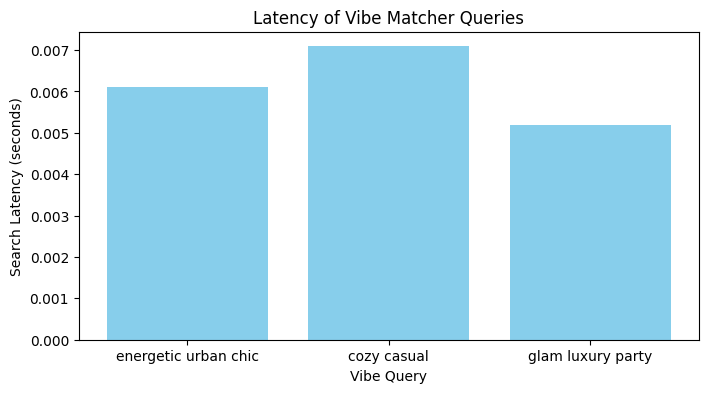

In [20]:
print(f"\nTotal queries: {len(queries)}")
print(f"Good matches (score > 0.7): {good_match_counts}")
print(f"Latency per query (seconds): {latencies}")

plt.figure(figsize=(8, 4))
plt.bar(range(len(queries)), latencies, tick_label=queries, color='skyblue')
plt.xlabel('Vibe Query')
plt.ylabel('Search Latency (seconds)')
plt.title('Latency of Vibe Matcher Queries')
plt.show()

In [21]:
print("""
Reflection:
- Accuracy will improve significantly using OpenAI API embeddings instead of mock embeddings.
- Integration with vector databases like Pinecone or FAISS would enable scalable, efficient similarity search.
- Handling edge cases with fallback messages improves user experience.
- Latency is low for small datasets but would increase with scale, backing the need for optimized search.
- Future work: Include vibe tag weighting and interactive UI for richer recommendations.
""")


Reflection:
- Accuracy will improve significantly using OpenAI API embeddings instead of mock embeddings.
- Integration with vector databases like Pinecone or FAISS would enable scalable, efficient similarity search.
- Handling edge cases with fallback messages improves user experience.
- Latency is low for small datasets but would increase with scale, backing the need for optimized search.
- Future work: Include vibe tag weighting and interactive UI for richer recommendations.

